In [1]:
def is_positive_background(img):
    """
    Returns a boolean version of `img` where the positive values are converted into True, the other values are False.
    """
    return img > 0.5

In [2]:
from torch.utils.data import Dataset
import os
from typing import List, Iterable, Optional
import tqdm

from __future__ import annotations

from torch.utils.data import Dataset
from typing import Optional, Dict, Any
import pandas as pd
import numpy as np
import torch
import os

try:
    import nibabel as nib  # solo usado si transform es None
except ImportError:
    nib = None


class MRIDataset3D(Dataset):
    """
    Minimal 3D MRI dataset that plays nicely with MONAI dict transforms.

    - Expects a DataFrame with column 'filepath' and, if training, 'filepath_label'.
    - If `transform` is provided, it should accept/return a dict with keys
      'image' and (optionally) 'label' (e.g., MONAI's Compose with LoadImaged, etc).
    - If `transform` is None, falls back to nibabel loading and returns torch tensors.

    Returns (by default) a dict with:
        {'image': Tensor [1,D,H,W], 'label': Tensor [1,D,H,W] (if available),
         'image_path': str, 'label_path': Optional[str]}
    """

    def __init__(
        self,
        df: pd.DataFrame,
        is_train: bool = True,
        transform: Optional[callable] = None,
    ) -> None:
        self.df = df.reset_index(drop=True)
        self.is_train = is_train
        self.transform = transform

        self._has_label = self.is_train and ("filepath_label" in self.df.columns)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        row = self.df.iloc[idx]
        #print("row:",row )
        img_path = row["filepath"]
        sample: Dict[str, Any] = {"image": img_path, "image_path": img_path}

        if self._has_label and pd.notna(row.get("filepath_label", None)):
            lab_path = row["filepath_label"]
            sample["label"] = lab_path
            sample["label_path"] = lab_path
        else:
            sample["label_path"] = ""

        #print("sample:",sample )
        if self.transform is not None:
            # MONAI-style: transform loads and returns tensors/MetaTensors
            out = self.transform(sample)
            # ensure the meta paths stay available
            out.setdefault("image_path", img_path)
            out.setdefault("label_path", sample.get("label_path", ""))
            return out

        # Fallback path: no transform -> direct nibabel load
        img_t = self._fallback_load(img_path)
        out = {"image": img_t, "image_path": img_path}

        if sample["label_path"] is not None:
            lab_t = self._fallback_load_label(sample["label_path"])
            out["label"] = lab_t
            out["label_path"] = sample["label_path"]

        return out


In [65]:
# =========================
# Inference MONAI 3D (0/1/2)
# SWI + Invertd + Ensemble
# =========================
import matplotlib.pyplot as plt
import os, re, copy
import numpy as np
import nibabel as nib
import pandas as pd
import torch
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader

from monai.data import Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, EnsureTyped, CropForegroundd, Resized, Invertd
)

# ---------- Constantes (ajústalas a lo entrenado) ----------
SPACING      = (1.0, 1.0, 1.0)
SPATIAL_SIZE = (96, 96, 96)
ROI_SIZE     = SPATIAL_SIZE
OVERLAP      = 0.25
SW_BATCH     = 2
N_CLASSES    = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Modelo ----------
import sys
sys.path.append("../")
#try:
from src.models import create_model
from src.cascade_utils import (
    get_roi_bbox_from_labels,
    get_roi_bbox_from_logits,
    crop_to_bbox,
    resize_volume,
)
roi_size = (96, 96, 96)
warmup_epochs = 80
roi_margin = 16
thr_roi = 0.2

#get_model  # tu UNeST
#except Exception:
#    get_model = None

# ---------- Transforms de TEST (mismos que validación) ----------
def get_test_transforms():
    return Compose([
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=False,select_fn=is_positive_background),
        Spacingd(keys=["image"], pixdim=SPACING, mode=("bilinear",)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image"], spatial_size=SPATIAL_SIZE, mode=("trilinear",)),
        EnsureTyped(keys=["image"], track_meta=True),
    ])

def get_val_transforms():
    return Compose([
        LoadImaged(keys=["image","label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        CropForegroundd(keys=["image","label"], source_key="image", allow_smaller=False,select_fn=is_positive_background),
        Spacingd(keys=["image","label"], pixdim=SPACING, mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE, mode=("trilinear","nearest")),
        EnsureTyped(keys=["image","label"], track_meta=True),
    ])


# ---------- Dataset de TEST ----------
class MRIDataset3DTest(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        data = []
        for _, r in df.iterrows():
            item = {"image": r["filepath"],"filepath": r["filepath"]}
            # si tienes columna opcional con máscara cerebral:
            if "brainmask_path" in r and isinstance(r["brainmask_path"], str):
                item["brainmask_path"] = r["brainmask_path"]
            # guarda ID si viene en el CSV para nombrar salida
            if "ID" in r:
                item["ID"] = r["ID"]
            data.append(item)
        super().__init__(data, transform=transform)

# ---------- Utilidades ----------
def build_outname(subject_id_or_path):
    """
    Construye LISAHF{ID}segprediction.nii.gz.
    Si no hay 'ID', extrae dígitos del filename.
    """
    base = str(subject_id_or_path)
    nums = re.findall(r"\d+", base)
    nid  = nums[-1] if nums else base
    return f"LISAHF{nid}segprediction.nii.gz"

def load_models(models_root, model_name):
    """Carga todos los folds ./fold_*/best_model.pth"""
    fold_dirs = []
    for d in sorted(os.listdir(models_root)):
        p = os.path.join(models_root, d)
        if os.path.isdir(p) and d.lower().startswith("fold_") and os.path.exists(os.path.join(p, "best_model.pth")):
            fold_dirs.append(p)
    assert len(fold_dirs) > 0, f"No se encontraron checkpoints en {models_root}/fold_*/best_model.pth"
    models = []
    for fd in fold_dirs:
        ckpt = os.path.join(fd, "best_model.pth")
        model = create_model(model_name).to(device=str(DEVICE)).eval()
        print("Leyendo checkpoint:", ckpt)
        model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
        model.eval()
        models.append(model)
    return fold_dirs, models

from copy import deepcopy

def _first_meta(meta_dict):
    """Convierte dict de listas (B=1) a dict por-elemento."""
    out = {}
    for k, v in meta_dict.items():
        # en MONAI, meta suele ser lista por batch; tomamos el 0 si es lista/tupla
        out[k] = v[0] if isinstance(v, (list, tuple)) else v
    return out

# ---------- Inference principal ----------
def run_inference(
    df_test_csv,
    models_root,
    output_dir,
    model_name="unest",
    mask_threshold=0.0,
    save_per_fold=True,
):

    os.makedirs(output_dir, exist_ok=True)
    if save_per_fold:
        os.makedirs(os.path.join(output_dir, "per_fold"), exist_ok=True)

    # 1) Carga DF y dataset
    df_test = pd.read_csv(df_test_csv)
    assert "filepath" in df_test.columns, "El CSV de test debe tener columna 'filepath'."
    test_tfm = get_test_transforms()
    #test_ds  = MRIDataset3DTest(df_test, transform=test_tfm)
    test_ds   = MRIDataset3D(df_test, is_train=False,  transform=test_tfm)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

    # 2) Carga modelos (todos los folds)
    fold_dirs, models = load_models(models_root, model_name)
    print(f"Usando {len(models)} folds:", fold_dirs)

    # 3) Invertd para probs (lo creamos una vez y lo reusamos por sample)
    #    OJO: se usa el MISMO objeto 'test_tfm' que aplicó el dataset
    def make_inv_for_elem(elem):
        # Invertd leerá 'pred_meta_dict' y 'image_meta_dict'
        return Invertd(
            keys="pred",
            transform=test_tfm,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            nearest_interp=False,   # LINEAL para PROBS
            to_tensor=True,
        )



    with torch.no_grad():
      for i, batch in enumerate(test_loader):
          # ----- rutas / affine en original -----
          # usa la columna "filepath" que pusiste en el Dataset de test
          img_path = batch["image_path"][0] if isinstance(batch["image_path"], list) else batch["image_path"]
          print("img_path:",img_path)
          nii      = nib.load(img_path)
          orig_img = nii.get_fdata()
          orig_aff = nii.affine

          # nombre de salida
          subject_id = batch.get("ID", [None])[0] if "ID" in batch else None
          out_name   = build_outname(subject_id if subject_id is not None else img_path)

          # ----- EXTRAER ELEMENTO 0 (sin batch) -----
          # imagen procesada (MetaTensor) sin dimensión de batch: (1, d, h, w)
          e_img  = batch["image"][0]
          # metadatos por elemento
          e_meta = _first_meta(batch["image"].meta)

          prob_sum = None

          for k, model in enumerate(models, start=1):
              # ---- inferencia SWI en espacio procesado ----
              with autocast():
                  # añade de nuevo el batch para el predictor: (1, 1, d, h, w)
                  tta_flips = [(0, 0, 0), (1, 0, 0)]#,
                  tta_flips = [(0, 0, 0), (0, 0, 1)]#, 
                  tta_flips = [(0, 0, 0), (1, 1, 0)]#
                  tta_flips = [(0, 0, 0), (1, 0, 1)]#
                  tta_flips = [(0, 0, 0), (0, 1, 1)]#
                  tta_flips = [(0, 0, 0), (1, 1, 1)]
                  tta_flips = [(0, 0, 0), (0, 1, 0)]#
                  #tta_flips = [(0, 1, 0)]#
                  outs = []
                  for fx, fy, fz in tta_flips:
                      xx = e_img
                      if fx: xx = xx.flip(1)
                      if fy: xx = xx.flip(2)
                      if fz: xx = xx.flip(3)
                      
                      print("xx:",xx.shape)
                      fig = plt.figure(figsize=(4,4))
                      plt.imshow(xx[0,:,50,:],cmap="gray")
                      plt.show()

                      lo = sliding_window_inference(
                          inputs=xx.unsqueeze(0).to(DEVICE),
                          roi_size=ROI_SIZE,
                          sw_batch_size=SW_BATCH,
                          predictor=model,
                          #overlap=OVERLAP,
                          mode="constant",#gaussian",
                      )
                      print("lo:",lo.shape)
                      if fz: lo = lo.flip(4)
                      if fy: 
                          lo = lo.flip(3)
                          lo = lo[:, [0, 2, 1], ...]

                          
                      if fx: lo = lo.flip(2)
                      outs.append(lo.cpu())

                  logits = torch.stack(outs, 0)
                  print("LOGITS:",logits.shape)
                  logits = logits.mean(0).to(DEVICE)
                  del outs, lo, xx

                  """
                  logits = sliding_window_inference(
                      inputs=e_img.unsqueeze(0).to(DEVICE),
                      roi_size=ROI_SIZE,
                      sw_batch_size=SW_BATCH,
                      predictor=model,
                      #overlap=OVERLAP,
                      mode="constant",#gaussian",
                  )
                  """
              bboxes = get_roi_bbox_from_logits(logits, thr=thr_roi, margin=roi_margin)

              logits_fold = torch.zeros_like(logits)
              for i, bb in enumerate(bboxes):
                  print("e_img:",e_img.shape)
                  img_roi = crop_to_bbox(e_img.unsqueeze(0)[i:i+1], bb)
                  print("img_roi:",img_roi.shape)                  
                  img_roi = resize_volume(img_roi, roi_size, mode="trilinear")
                  print("img_roi:",img_roi.shape)                  
                  probs_proc_el = torch.softmax(logits, dim=1).cpu()[0]
                  pred_lab = np.argmax(probs_proc_el, axis=0).astype(np.uint8)
                  print("pred_lab:",pred_lab.shape)
                  logits2 = model(img_roi.to(DEVICE))
                  z0, y0, x0, z1, y1, x1 = bb
                  logits2_up = resize_volume(logits2, (z1 - z0, y1 - y0, x1 - x0), mode="trilinear")[0]
                  logits_fold[:, :, z0:z1, y0:y1, x0:x1] = logits2_up.cpu()

                  probs_proc_el2 = torch.softmax(logits_fold, dim=1).cpu()[0]
                  pred_lab2 = np.argmax(probs_proc_el2, axis=0).astype(np.uint8)

                  fig = plt.figure(figsize=(15,15))
                  plt.subplot(1,4,1)
                  plt.imshow(e_img[0,:,50,:],cmap="gray")
                  plt.subplot(1,4,2)
                  plt.imshow(img_roi[0,0,:,50,:],cmap="gray")
                  plt.subplot(1,4,3)
                  plt.imshow(pred_lab[:,50,:])
                  plt.subplot(1,4,4)
                  plt.imshow(pred_lab2[:,50,:])
                  plt.show()
                  raise
                  

              # softmax y QUITAR batch -> (C, d, h, w)
              probs_proc_el = torch.softmax(logits, dim=1).cpu()[0]

              # ---- Invertd: usa el MISMO pipeline y los metadatos del elemento ----
              elem = {
                  "image": e_img,                   # (1, d, h, w) MetaTensor
                  "image_meta_dict": e_meta,        # meta de UN SOLO elemento
                  "pred": probs_proc_el,            # (C, d, h, w)  << SIN batch
                  "pred_meta_dict": deepcopy(e_meta),
              }
              inv = Invertd(
                  keys="pred",
                  transform=test_tfm,       # el pipeline de test
                  orig_keys="image",
                  meta_keys="pred_meta_dict",
                  orig_meta_keys="image_meta_dict",
                  nearest_interp=False,     # lineal para probabilidades
                  to_tensor=True,
              )
              elem = inv(elem)

              # probabilidades en ESPACIO ORIGINAL: (C, Z, Y, X)
              probs_orig = elem["pred"].numpy()
              prob_sum = probs_orig if prob_sum is None else (prob_sum + probs_orig)

              # ---- guardado por-fold (opcional) ----
              if save_per_fold:
                  lab_k = np.argmax(probs_orig, axis=0).astype(np.uint8)
                  # máscara cerebral en ORIGINAL
                  if ("brainmask_path" in batch and isinstance(batch["brainmask_path"][0], str)
                          and os.path.exists(batch["brainmask_path"][0])):
                      bm = (nib.load(batch["brainmask_path"][0]).get_fdata() > 0).astype(np.uint8)
                  else:
                      bm = (orig_img > mask_threshold).astype(np.uint8)
                  lab_k = (lab_k * (bm > 0)).astype(np.uint8)

                  fold_dir  = os.path.join(output_dir, "per_fold", f"fold_{k}")
                  os.makedirs(fold_dir, exist_ok=True)
                  out_path_k = os.path.join(fold_dir, out_name.replace(".nii.gz", f"_fold{k}.nii.gz"))
                  nib.save(nib.Nifti1Image(lab_k, orig_aff), out_path_k)

          # ---- ensamble final ----
          prob_avg = prob_sum / float(len(models))
          pred_lab = np.argmax(prob_avg, axis=0).astype(np.uint8)

          # máscara final (original)
          if ("brainmask_path" in batch and isinstance(batch["brainmask_path"][0], str)
                  and os.path.exists(batch["brainmask_path"][0])):
              brain_mask = (nib.load(batch["brainmask_path"][0]).get_fdata() > 0).astype(np.uint8)
          else:
              brain_mask = (orig_img > mask_threshold).astype(np.uint8)
          pred_lab = (pred_lab * (brain_mask > 0)).astype(np.uint8)

          out_path = os.path.join(output_dir, out_name)
          nib.save(nib.Nifti1Image(pred_lab, orig_aff), out_path)
          print(f"[{i+1}/{len(test_ds)}] guardado: {out_path}")


Leyendo checkpoint: /data/cristian/projects/med_data/rise-miccai/task-2/3d_models/predictions/efficientnet-b7_mixup_hard_dice_ce_symmetry_fine/fold_models/fold_1/best_model.pth
Usando 1 folds: ['/data/cristian/projects/med_data/rise-miccai/task-2/3d_models/predictions/efficientnet-b7_mixup_hard_dice_ce_symmetry_fine/fold_models/fold_1']
img_path: /data/cristian/projects/med_data/rise-miccai/task-2-val/552/158977552/LISA_VALIDATION_0001_ciso.nii.gz
xx: torch.Size([1, 96, 96, 96])


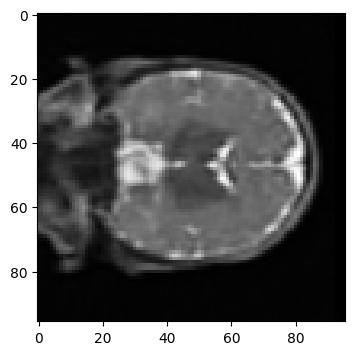

lo: torch.Size([1, 3, 96, 96, 96])
xx: torch.Size([1, 96, 96, 96])


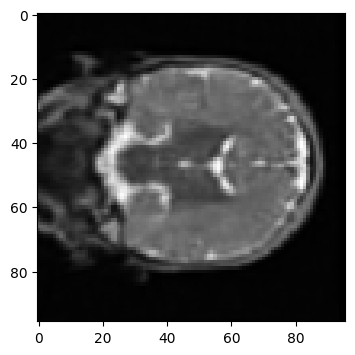

lo: torch.Size([1, 3, 96, 96, 96])
LOGITS: torch.Size([2, 1, 3, 96, 96, 96])
e_img: torch.Size([1, 96, 96, 96])
img_roi: torch.Size([1, 1, 63, 50, 49])
img_roi: torch.Size([1, 1, 96, 96, 96])
pred_lab: (96, 96, 96)


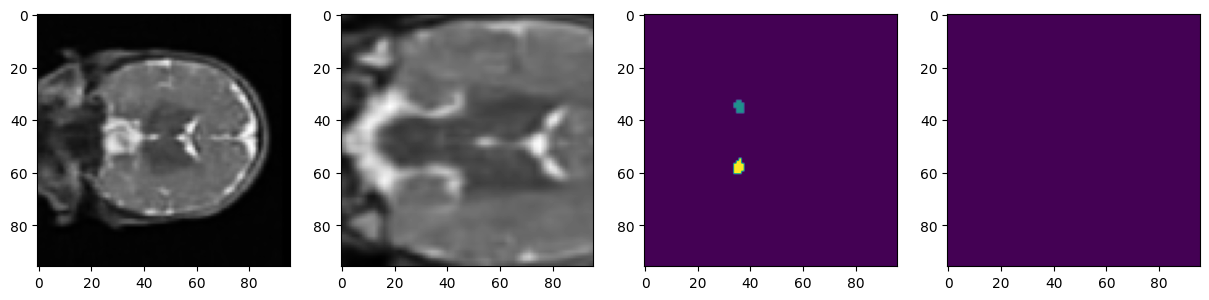

RuntimeError: No active exception to reraise

In [66]:

df_test_csv = "../results/preprocessed_data/task2/df_test_hipp.csv"



run_inference(
    df_test_csv=df_test_csv,
    #models_root="./fold_models",   # donde están fold_1/best_model.pth, fold_2/..., etc.
    models_root="/data/cristian/projects/med_data/rise-miccai/task-2/3d_models/predictions/efficientnet-b7_mixup_hard_dice_ce_symmetry_fine/fold_models",
    output_dir ="/data/cristian/projects/med_data/rise-miccai/task-2/3d_models/predictions/efficientnet-b7_mixup_hard_dice_ce_symmetry_fine/predictions",
    model_name="efficientnet-b7",            # o "unest"
    mask_threshold=0.0,            # si no tienes brainmask externa
    save_per_fold=True,            # guarda también por-fold en subcarpetas
)                          

In [ ]:
#scp -r va0831@148.100.72.4:/data/cristian/projects/med_data/rise-miccai/task-2/3d_models/predictions/unest_mixup_hard_dice_ce_symmetry/predictions/ .
